## Test the segmentation of the images using OpenCV
#### Segmentation is done on a preprocessed image, where a proper threshold has been applied

In [69]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from cv2 import cvtColor, COLOR_BGR2RGB

dataset_path = '../dataset/'
test_pictures_path = dataset_path + 'tif_merged_processed/'

In [70]:
picture = '1w_D Merged_Processed.tif'
picture_path = test_pictures_path + picture

______________________________

In [71]:
img = cv2.imread(picture_path, cv2.IMREAD_GRAYSCALE)
assert img is not None, 'No image found.'   # asert check if true, otherwise raise an AssertionError with an optional error message

Here one should use the most appropriate threshold

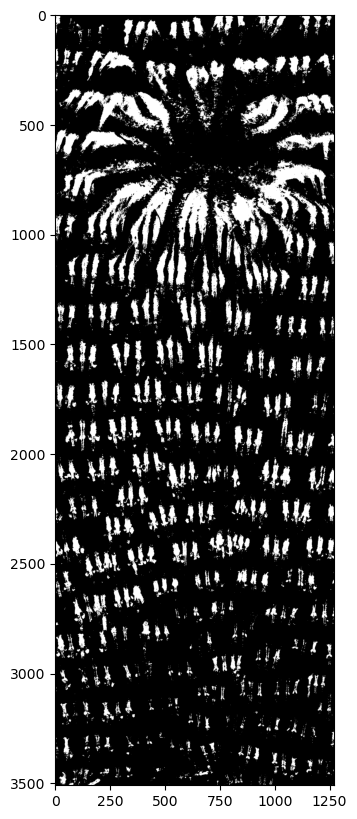

In [72]:
ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.figure(figsize=(10, 10))
plt.imshow(thresh, cmap='gray')

Noise removal

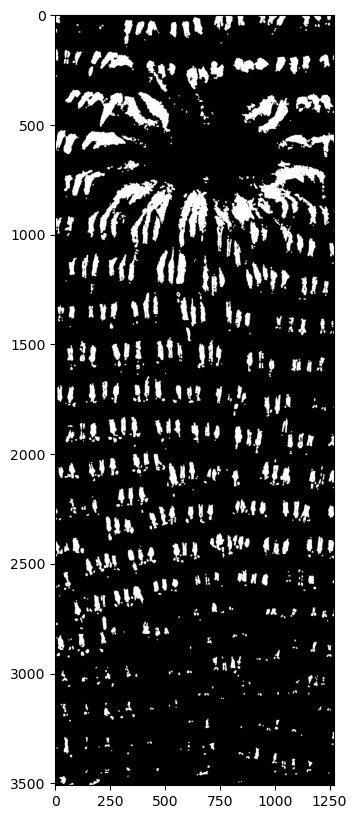

In [73]:
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
plt.figure(figsize=(10, 10))
plt.imshow(opening, cmap='gray')

Sure background area

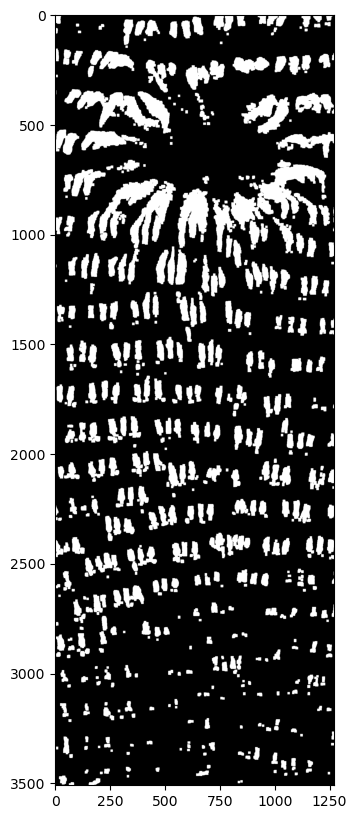

In [74]:
sure_bg = cv2.dilate(opening, kernel, iterations=3)
plt.figure(figsize=(10, 10))
plt.imshow(sure_bg, cmap='gray')

Sure foreground

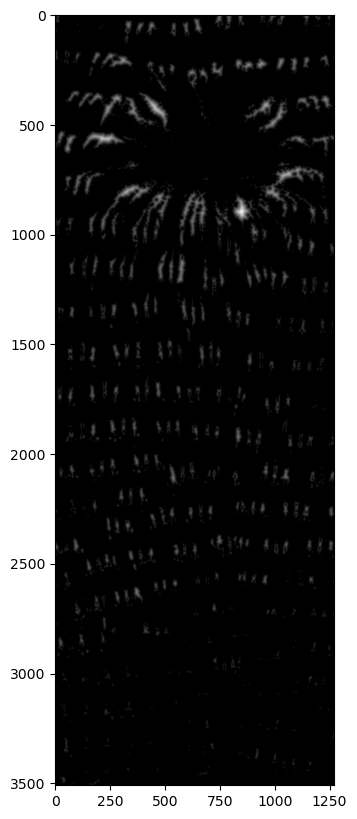

In [75]:
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)
plt.figure(figsize=(10, 10))
plt.imshow(dist_transform, cmap='gray')


Finding unknown region

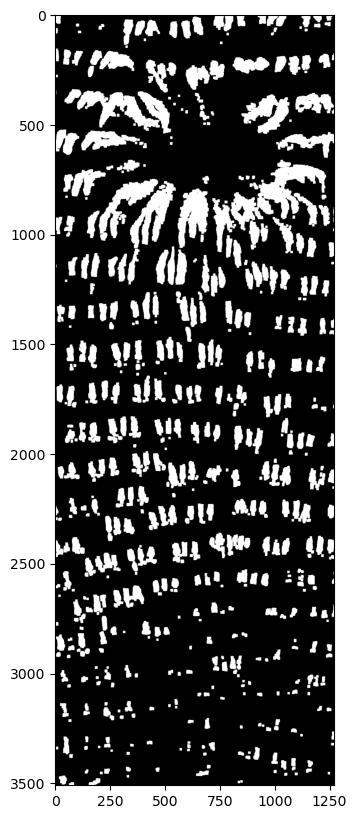

In [76]:
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)
plt.figure(figsize=(10, 10))
plt.imshow(unknown, cmap='gray')

_____________________________________________

## Create a marker

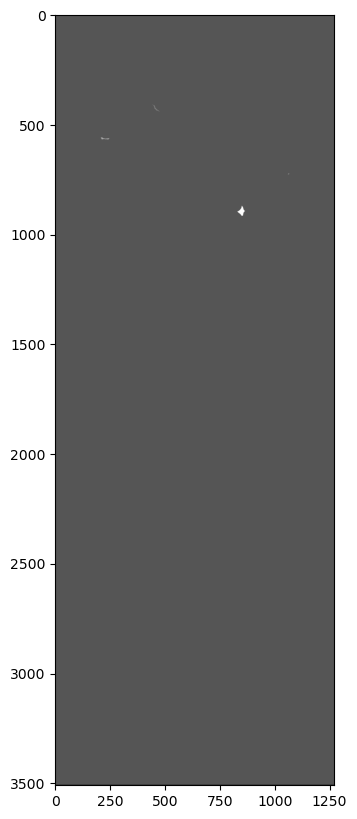

In [82]:
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 155] = 0

markers = cv2.watershed(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR), markers)

plt.figure(figsize=(10, 10))
plt.imshow(markers, cmap='gray')

In [81]:
#Assuming img and markers are defined before this point
# Convert img to 3 channels if needed
if img.shape[-1] == 1:
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Convert markers to 32-bit signed
markers = markers.astype(np.int32)

# Apply watershed algorithm
markers = cv2.watershed(img, markers)

# Color the regions marked as -1 in red
img[markers == -1] = [150, 0, 0]

# Plot the result
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

error: OpenCV(4.6.0) /croot/opencv-suite_1691620365762/work/modules/imgproc/src/segmentation.cpp:161: error: (-215:Assertion failed) src.type() == CV_8UC3 && dst.type() == CV_32SC1 in function 'watershed'
